In [1]:
using Interpolations, Plots, Unitful, StructArrays, UnPack, HDF5
using Flight.Atmosphere: ISA_layers, ISAData, p_std, T_std, g_std, R
using Flight.Geodesy: AltGeop

p_std_inHg = 101325 / 3386.389

ω_rated = 2700 #RPM
P_rated = 200 #HP

n_idle_std = 0.25
π_idle_std = 0.01
μ_idle_std = 9/p_std_inHg
fname = "piston.h5"

"piston.h5"

### Definitions

For implementation, define the following normalized variables
$$\pi = \dfrac{P}{P_{rated}}$$
$$n = \dfrac{\omega}{\omega_{rated}}$$
$$\mu = \dfrac{MAP}{p_{std}}$$

In [2]:
β = ISA_layers[1].β

δ_from_p(p) = (p/p_std) ^ (1+β*R/(2*g_std)) #computes normalized δ 

function δ_from_h(h) #computes normalized δ
    @unpack p, T = ISAData(AltGeop(h))
    p / p_std / √(T / T_std)
end

@assert δ_from_h(1345) ≈δ_from_p(ISAData(AltGeop(1345)).p)

### Part Throttle Power at Standard Conditions

We need a 2D table providing $\pi_{ISA,std}(n,\mu)$.

From the graph we see that the function $\pi_{ISA,std}(n,\mu)$ is linear in $\mu$. Therefore we need only two data points for each $n$: $(\mu_{1}(n), \pi_{ISA,std}(n,\mu_1(n)))$ and $(\mu_{2}(n), \pi_{ISA,std}(n, \mu_2(n)))$.

However, for a 2D table we need these two $\mu$ values to be the same across all values of $n$. So for each $n$, we construct a 1D linear interpolator, resample $\pi_{std}$ at two $\mu$ values, arbitrary but equal for all $n$, then build the 2D interpolator.

For $n > 1$, if we were to simply extrapolate the values in the graph, power would increase indefinitely with engine speed, which we know is not realistic. To avoid this, we add two extra $\pi$ entries at $n_{N+2}, n_{N+1} > 1$, with power reaching a peak between $n_{N}$ and $n_{N+1}$, then decreasing between $n_{N+1}$ and $n_{N+2}$, both for $\mu_1$ and $\mu_2$. The values of $\mu_1$ and $\mu_2$ for these synthetic $n$ values are simply extrapolations. 


n_range_π = [n_idle_std * ω_rated, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2900, 1.2ω_rated] / ω_rated = [0.25, 0.6666666666666666, 0.7037037037037037, 0.7407407407407407, 0.7777777777777778, 0.8148148148148148, 0.8518518518518519, 0.8888888888888888, 0.9259259259259259, 0.9629629629629629, 1.0, 1.0740740740740742, 1.2]
μ_std_1 = [μ_idle_std * p_std_inHg, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, μ_idle_std * p_std_inHg] / p_std_inHg = [0.3007895484826055, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.5681580360226992, 0.3007895484826055]


π_ISA_std_1 = [π_idle_std * P_rated 54 61 67 72 76 81 85.5 90 95.1 99.5 99.5 π_idle_std * P_rated] / P_rated |> vec = [0.01, 0.27, 0.305, 0.335, 0.36, 0.38, 0.405, 0.4275, 0.45, 0.4755, 0.4975, 0.4975, 0.01]


μ_std_2 = [p_std_inHg 25 25.55 26.15 26.88 27.3 28.1 28.75 28.7 28.65 28.6 28.5 p_std_inHg] / p_std_inHg |> vec = [1.0, 0.835526523562793, 0.8539081070811745, 0.8739607436466814, 0.898358118134715, 0.9123949637305699, 0.9391318124845793, 0.9608555020972119, 0.9591844490500864, 0.9575133960029607, 0.9558423429558353, 0.952500236861584, 1.0]
π_ISA_std_2 = [0.1P_rated 97.8 109.5 121.8 136 145.75 162 176 184 193 200 200 0.1P_rated] / P_rated |> vec = [0.1, 0.489, 0.5475, 0.609, 0.68, 0.72875, 0.81, 0.88, 0.92, 0.965, 1.0, 1.0, 0.1]
μ_range_π = [μ_idle_std * p_std_inHg, 17, 30] / p_std_inHg = [0.3007895484826055, 0.5681580360226992, 1.0026318282753517]


interp_π_ISA_std(0.25, 0.25) * P_rated = 2.0
interp_π_ISA_std(1800 / ω_rated, 17 / p_std_inHg) * P_rated = 54.0
interp_π_ISA_std(2400 / ω_rated, 24 / p_std_inHg) * P_rated = 139.41489361702128
interp_π_ISA_std(2500 / ω_rated, 26.5 / p_std_inHg) * P_rated = 166.32478632478632
interp_π_ISA_std(1950 / ω_rated, 20.5 / p_std_inHg) * P_rated = 84.40777490173521
interp_π_ISA_std(2150 / ω_rated, 27 / p_std_inHg) * P_rated = 140.24788726858222


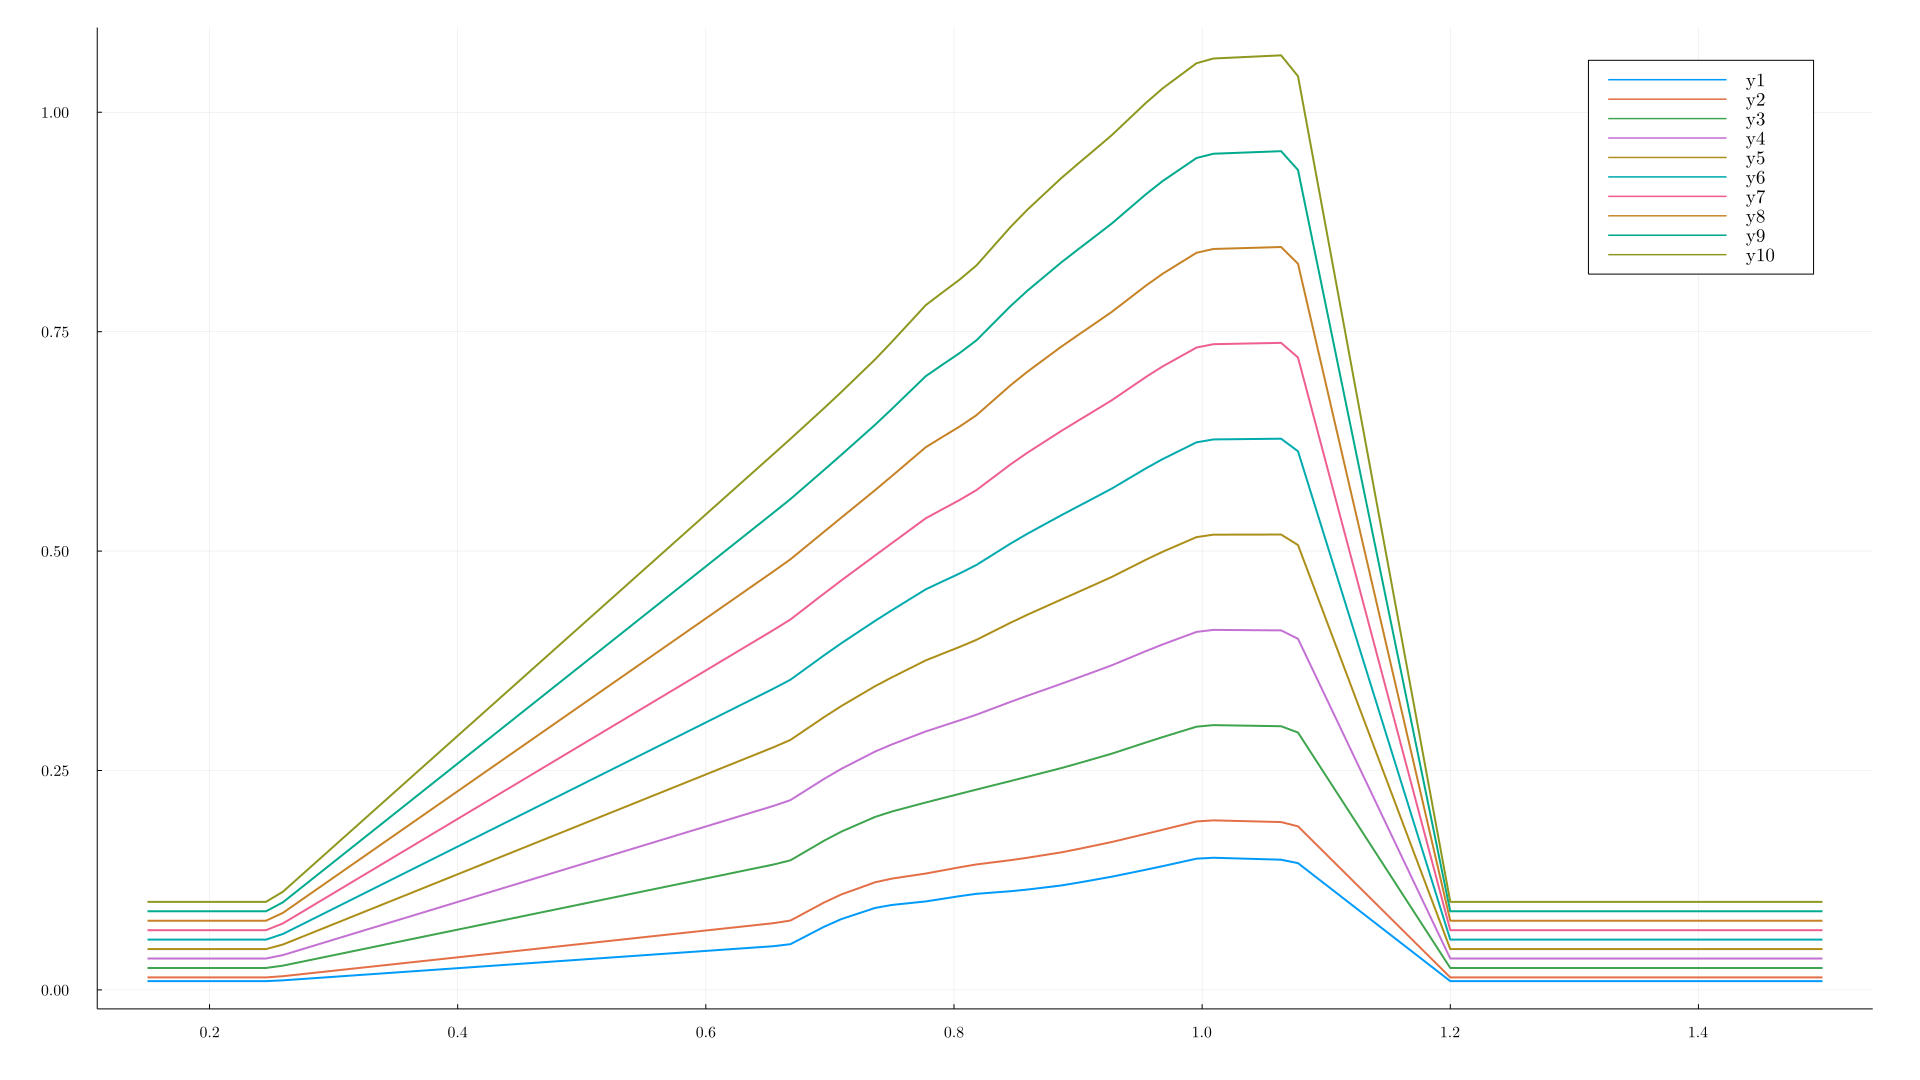

In [3]:
function build_interp_π_ISA_std()

    @show n_range_π = [n_idle_std*ω_rated, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2900, 1.2ω_rated]/ω_rated

    @show μ_std_1 = [μ_idle_std*p_std_inHg, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, μ_idle_std*p_std_inHg]/p_std_inHg #each value in n_range_π
    @show π_ISA_std_1 = [π_idle_std*P_rated 54 61 67 72 76 81 85.5 90 95.1 99.5 99.5 π_idle_std*P_rated] / P_rated  |> vec

    @show μ_std_2 = [p_std_inHg 25 25.55 26.15 26.88 27.3 28.1 28.75 28.7 28.65 28.6 28.50 p_std_inHg] / p_std_inHg |> vec
    @show π_ISA_std_2 = [0.1P_rated 97.8 109.5 121.8 136 145.75 162 176 184 193 200 200 0.1P_rated] / P_rated |> vec
    
    @show μ_range_π = [μ_idle_std*p_std_inHg, 17, 30] / p_std_inHg

    π_ISA_std_data = Array{Float64,2}(undef, (length(n_range_π), length(μ_range_π)))
    for (i, n) in enumerate(n_range_π)
        interp_π_ISA_std_1D = LinearInterpolation([μ_std_1[i], μ_std_2[i]], [π_ISA_std_1[i], π_ISA_std_2[i]], extrapolation_bc = Line())
        π_ISA_std_data[i,:] = interp_π_ISA_std_1D.(μ_range_π)
    end

    interp_π_ISA_std = LinearInterpolation((n_range_π, μ_range_π), π_ISA_std_data, extrapolation_bc = ((Flat(), Flat()), (Flat(), Line())))
end

interp_π_ISA_std = build_interp_π_ISA_std()

@show interp_π_ISA_std(0.25, 0.25) * P_rated
@show interp_π_ISA_std(1800/ω_rated, 17/p_std_inHg) * P_rated
@show interp_π_ISA_std(2400/ω_rated, 24/p_std_inHg) * P_rated
@show interp_π_ISA_std(2500/ω_rated, 26.5/p_std_inHg) * P_rated
@show interp_π_ISA_std(1950/ω_rated, 20.5/p_std_inHg) * P_rated
@show interp_π_ISA_std(2150/ω_rated, 27/p_std_inHg) * P_rated

# n_plot = [0.25ω_rated, 0.35ω_rated, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 1.2ω_rated]/ω_rated
n_plot = range(0.15, 1.5, length = 100)
δ_plot = range(1, δ_from_h(32000*0.3048), length = 10)
μ_plot = range(0.25p_std_inHg, 30, length = 10)/p_std_inHg

π_std_plot = [interp_π_ISA_std(n, μ) for (n, μ) in Iterators.product(n_plot, μ_plot)]
# plot(μ_plot, π_std_plot')
plot(n_plot, π_std_plot)

# h5open(fname, "w") do fid

#     create_group(fid, "pi_ISA_std")
#     π_ISA_std = fid["pi_ISA_std"]

#     π_ISA_std["n"] = collect(n_range)
#     π_ISA_std["mu"] = collect(μ_range_std)
#     π_ISA_std["data"] = π_ISA_std_data

# end


### $\delta_{wot}(n, \mu)$

δ_wot_1 = δ_from_h.(h_wot_1) = [0.45488826288341005, 0.5226221765054068, 0.5872662297982473, 0.652213060817433, 0.7176582379283565, 0.7814324368713697, 0.8438661990455512, 0.9056301912743312, 0.9645379356818949]
δ_wot_2 = δ_from_h.(h_wot_2) = [0.46373238813431905, 0.5295134805614843, 0.5959069556786906, 0.6615988634589004, 0.726507891003391, 0.7922561322993095, 0.855366275187289, 0.9208488318821639, 0.9805317464835176]


(interp_δ_wot(2400 / ω_rated, 24 / p_std_inHg), δ_from_h(4850 * 0.3048)) = (0.8515329164733765, 0.851039335842428)
(interp_δ_wot(2100 / ω_rated, 20 / p_std_inHg), δ_from_h(9600 * 0.3048)) = (0.7206081222867012, 0.7227046924579216)
(interp_δ_wot(1800 / ω_rated, 28 / p_std_inHg), δ_from_h(1200 * 0.3048)) = (0.9645379356818949, 0.9613640450620135)
(interp_δ_wot(1, 28.65 / p_std_inHg), δ_from_h(0 * 0.3048)) = (0.9999286937289575, 1.0)


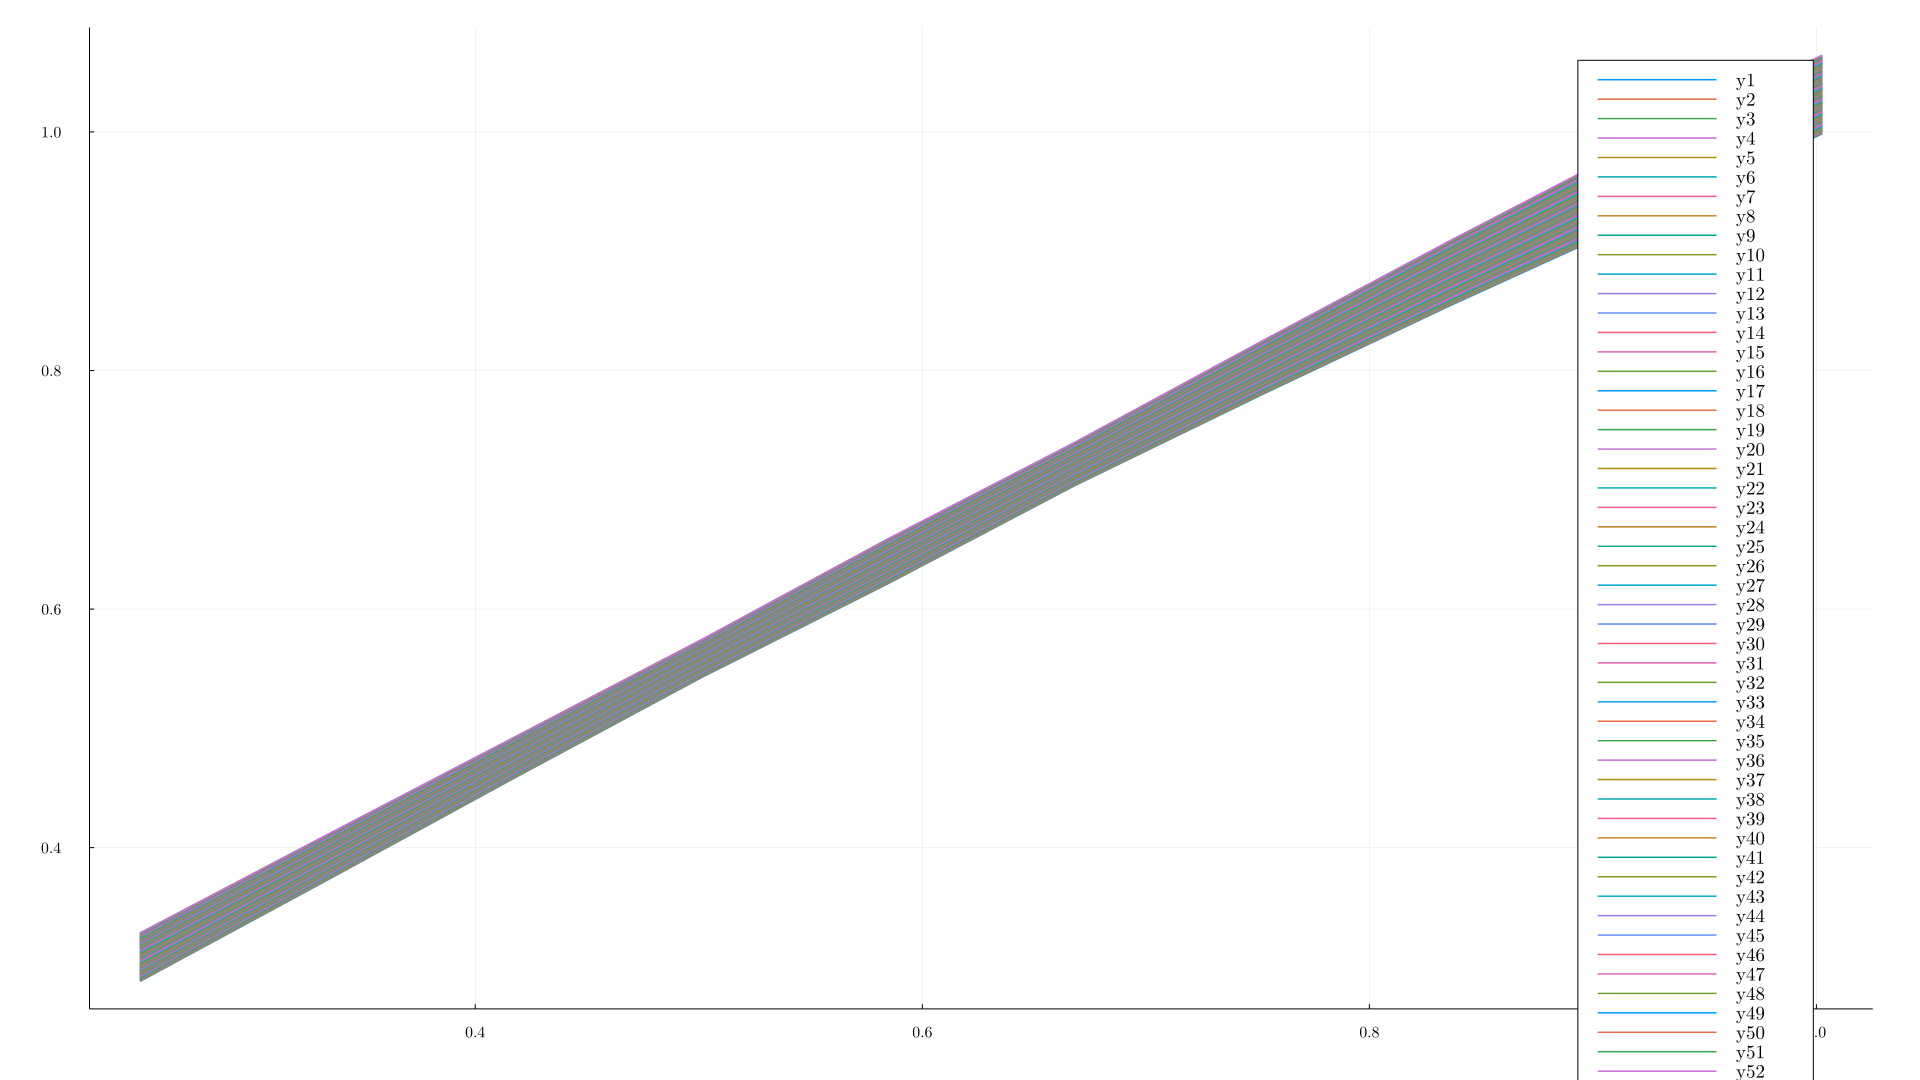

In [4]:
function build_δ_wot_interp()

    n_1_wot = 1800/ω_rated
    n_2_wot = 2700/ω_rated

    #take the pressure altitude values in kft read from the graph and convert them
    #to meters
    h_wot_1 = ustrip.(u"m", [22.2, 18.55, 15.4, 12.5, 9.8, 7.35, 5.1, 3.00, 1.1]*1000u"ft")
    h_wot_2 = ustrip.(u"m", [21.7, 18.2, 15.0, 12.1, 9.45, 6.95, 4.7, 2.5, 0.6]*1000u"ft")

    #compute the corresponding δ values
    @show δ_wot_1 = δ_from_h.(h_wot_1)
    @show δ_wot_2 = δ_from_h.(h_wot_2)

    n_range_wot = range(1800, 2700, step = 100)/ω_rated
    μ_range_wot = range(12, 28, step = 2)/p_std_inHg #24 26 28
    δ_wot_data = Array{Float64}(undef, length(n_range_wot), length(μ_range_wot))
    for (i, μ) in enumerate(μ_range_wot)
        interp_δ_wot_1D = LinearInterpolation([n_1_wot, n_2_wot], [δ_wot_1[i], δ_wot_2[i]], extrapolation_bc = Line())
    δ_wot_data[:,i] = interp_δ_wot_1D.(n_range_wot)
    end

    interp_δ_wot = extrapolate(scale(interpolate(δ_wot_data, BSpline(Linear())), n_range_wot, μ_range_wot), Line())
end

interp_δ_wot = build_δ_wot_interp()

@show interp_δ_wot(2400/ω_rated, 24/p_std_inHg), δ_from_h(4850*0.3048)
@show interp_δ_wot(2100/ω_rated, 20/p_std_inHg), δ_from_h(9600*0.3048)
@show interp_δ_wot(1800/ω_rated, 28/p_std_inHg), δ_from_h(1200*0.3048)
@show interp_δ_wot(1, 28.65/p_std_inHg), δ_from_h(0*0.3048)

# h5open(fname, "w") do fid

#     create_group(fid, "delta_wot")
#     δ_wot = fid["delta_wot"]

#     δ_wot["n"] = collect(n_range)
#     δ_wot["mu"] = collect(μ_range_wot)
#     δ_wot["data"] = δ_wot_data

# end

δ_wot_plot = [interp_δ_wot(n,μ) for (n,μ) in Iterators.product(n_plot, μ_plot)]
plot(μ_plot, δ_wot_plot')
# plot(n_plot, δ_wot_plot)

### $\mu_{wot}(n, \delta)$

For each $n$ obtain a 1D linear interpolator $\mu_{wot,1D}(\delta)$. Then evaluate it at some predefined $\delta$ range. Finally, use the results for all $n$ values to construct the 2D interpolator $\mu_{wot}(n, \delta)$.

In [6]:
function build_interp_δ_wot()
    δ_range_wot = range(δ_from_h(23e3*.3048), 1, length = 100)

    n_range_wot = range(1800, 2700, step = 100)/ω_rated
    μ_range_wot = range(12, 28, step = 2)/p_std_inHg #24 26 28
    μ_wot_data = Array{Float64}(undef, length(n_range_wot), length(δ_range_wot))
    for (i, n) in enumerate(n_range_wot)
        δ_wot_1D = interp_δ_wot(n, μ_range_wot)
        interp_μ_wot_1D = LinearInterpolation(δ_wot_1D, μ_range_wot, extrapolation_bc = Line())
        μ_wot_data[i, :] = interp_μ_wot_1D.(δ_range_wot)
    end

    interp_μ_wot = extrapolate(scale(interpolate(μ_wot_data, BSpline(Linear())), n_range_wot, δ_range_wot), Line())

end

interp_μ_wot = build_interp_δ_wot()

@show interp_μ_wot(1, interp_δ_wot(1, 1))
@show interp_μ_wot(1800/ω_rated, δ_from_h(12500*0.3048)) * p_std_inHg
@show interp_μ_wot(2050/ω_rated, δ_from_h(5000*0.3048)) * p_std_inHg

μ_wot_plot = [interp_μ_wot(n,p) for (n,p) in Iterators.product(n_plot, δ_plot)]
plot(δ_plot, μ_wot_plot')

#μ(n, thr, δ) = μ_wot(n, δ)(μ_idle_ratio + thr * (1-μ_idle_ratio))

#for n_idle = 0.25, thr = 0, δ = 1 (std)
#μ(n_idle, 0, 1) = μ_wot(n_idle, 1) * μ_idle_ratio.

#therefore, by specifying μ(n_idle, 0, 1) = μ_std_idle we can compute
#idle_ratio as:
@show interp_μ_wot(0.25, 1)
@show interp_μ_wot(1, 1)
@show μ_idle_ratio = 0.25 / interp_μ_wot(0.25, 1)

#here
#μ_std_idle = 0.25
#π_std_idle = 0.01

#note that, at altitude and part throttle, μ may be even smaller than
#μ_std_idle. we need to be aware of this when constructing the WOT tables
    
# h5open(fname, "w") do fid

#     create_group(fid, "mu_wot")
#     μ_wot = fid["mu_wot"]

#     μ_wot["n"] = collect(n_range)
#     μ_wot["delta"] = collect(δ_range_wot)
#     μ_wot["data"] =μ_wot_data

# end

interp_μ_wot(1, interp_δ_wot(1, 1)) = 0.9999999999999998
interp_μ_wot(1800 / ω_rated, δ_from_h(12500 * 0.3048)) * p_std_inHg = 17.999681055684242
interp_μ_wot(2050 / ω_rated, δ_from_h(5000 * 0.3048)) * p_std_inHg = 23.989440425590885


interp_μ_wot(0.25, 1) = 0.9993410552713519
interp_μ_wot(1, 1) = 0.957593255749959
μ_idle_ratio = 0.25 / interp_μ_wot(0.25, 1) = 0.25016484480577783


0.25016484480577783

Is it justified for the $\mu_{wot}(n,\delta)$ and $\delta_{wot}(n,\mu)$ mappings to be extrapolated linearly? We can reason this with $\mu_{wot}(n,\delta)$; since one mapping is the inverse of the other, and they are linear, the conclusion will apply for both of them. For a given $n$, as $\delta$ grows, $\mu_{wot}$ will keep growing indefinitely, since the air pressure keeps increasing. And for a given $\delta$, as $n$ grows, $\mu_{wot}$ will also keep falling indefinitely, since the engine sucks more air and the manifold vacuum increases. The fact that the brake power decreases due to increasing losses for $n > 1$ does not change these facts.


n_range_π = [n_idle_std * ω_rated, 1800, 2700, 2900, 1.2ω_rated] / ω_rated = [0.25, 0.6666666666666666, 1.0, 1.0740740740740742, 1.2]
δ_wot_1 = δ_from_h.([40, 23, 23, 23, 40] * 1000 * 0.3048) = [0.21345435288527098, 0.44101522797864756, 0.44101522797864756, 0.44101522797864756, 0.21345435288527098]
π_ISA_wot_1 = [π_idle_std * P_rated 46 81.8 81.8 π_idle_std * P_rated] / P_rated |> vec = [0.01, 0.23, 0.409, 0.409, 0.01]


π_ISA_wot_2 = [interp_π_ISA_std(n, interp_μ_wot(n, 1)) for n = n_range_π] = [0.09991518286740476, 0.6040841302627937, 1.002269459101936, 1.001364597502365, 0.09313427724182703]
δ_range_π = δ_from_h.([40, 0] * 1000 * 0.3048) = [0.21345435288527098, 1.0]
interp_π_ISA_wot(2300 / ω_rated, δ_from_h(24000 * 0.3048)) * P_rated = 62.89610649144796
interp_π_ISA_wot(1900 / ω_rated, δ_from_h(12000 * 0.3048)) * P_rated = 81.76055310464668


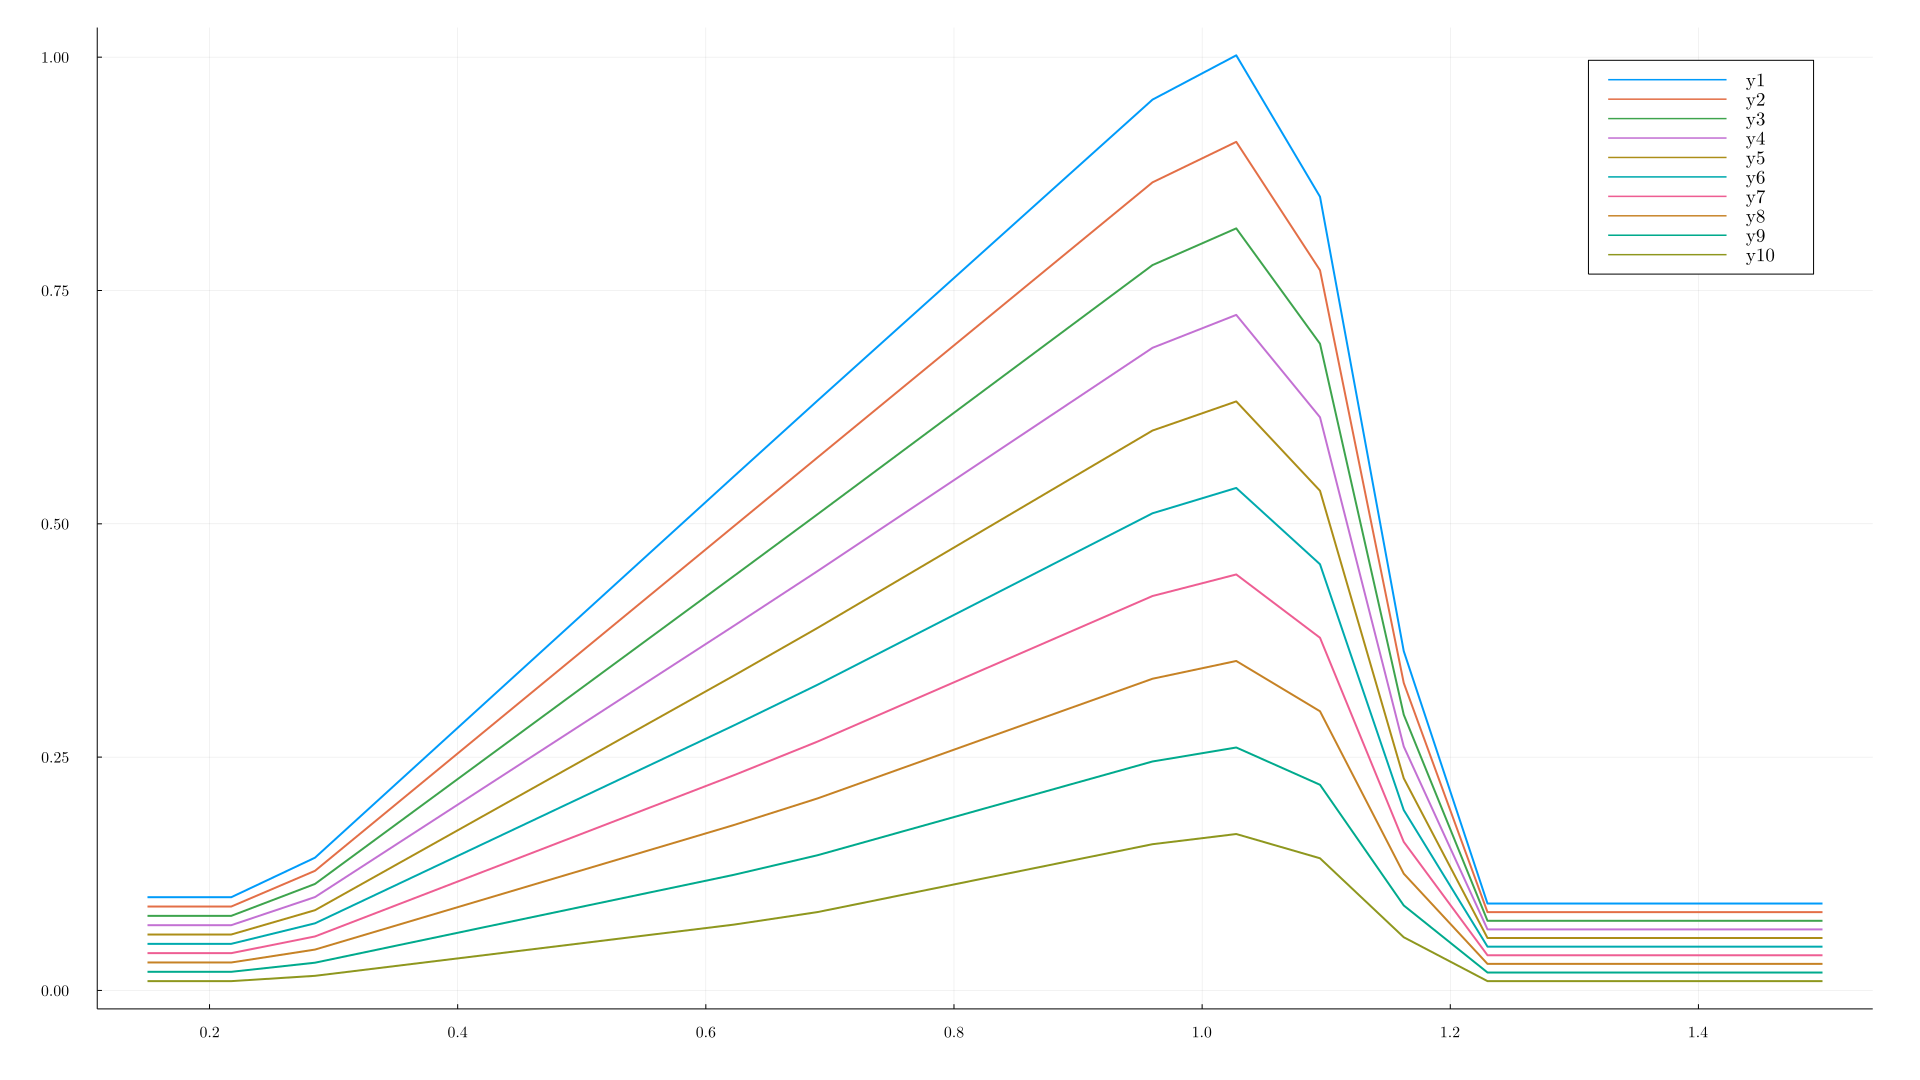

In [7]:
function build_interp_π_wot()

    @show n_range_π = [n_idle_std*ω_rated, 1800, 2700, 2900, 1.2ω_rated]/ω_rated

    @show δ_wot_1 = δ_from_h.([40, 23, 23, 23, 40]*1000*.3048)
    @show π_ISA_wot_1 = [π_idle_std*P_rated 46 81.8 81.8 π_idle_std*P_rated] / P_rated |> vec

    δ_wot_2 = ones(length(n_range_π))
    @show π_ISA_wot_2 = [interp_π_ISA_std(n, interp_μ_wot(n, 1)) for n in n_range_π]

    @show δ_range_π = δ_from_h.([40, 0]*1000*0.3048)

    π_ISA_wot_data = Array{Float64,2}(undef, (length(n_range_π), length(δ_range_π)))
    for (i, n) in enumerate(n_range_π)
        interp_π_ISA_wot_1D = LinearInterpolation([δ_wot_1[i], δ_wot_2[i]], [π_ISA_wot_1[i], π_ISA_wot_2[i]], extrapolation_bc = Line())
        π_ISA_wot_data[i,:] = interp_π_ISA_wot_1D.(δ_range_π)
    end

    interp_π_ISA_wot = LinearInterpolation((n_range_π,δ_range_π), π_ISA_wot_data, extrapolation_bc = ((Flat(), Flat()), (Flat(), Line())))

end

interp_π_ISA_wot = build_interp_π_wot()

@show interp_π_ISA_wot(2300/ω_rated, δ_from_h(24000*.3048))*P_rated
@show interp_π_ISA_wot(1900/ω_rated, δ_from_h(12000*.3048))*P_rated

let
# n_plot = [0.15ω_rated, 0.25ω_rated, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700]/ω_rated
n_plot = range(0.15, 1.5, length = 21)
δ_plot = range(1, δ_from_h(40000*0.3048), length = 10)
π_wot_plot = [interp_π_ISA_wot(n,p) for (n,p) in Iterators.product(n_plot, δ_plot)]
# plot(δ_plot, π_wot_plot')
plot(n_plot, π_wot_plot)
end


In [8]:
# function compute_Pbar_ISA(thr, nbar, δ)

#     #compute the wide-open throttle MAP for the given RPMs and altitude
#     @show Mbar_wot = interp_Mbar_wot(nbar, δ)
#     idle_MAP_ratio = 0.4
#     #this can be tuned so that the engine idles at appropriate RPMs with the
#     #chosen propeller
#     @show Mbar = Mbar_wot * (idle_MAP_ratio + thr * (1 - idle_MAP_ratio))

#     #δ at which our Mbar would be Mbar_wot
#     @show δ_wot = interp_δ_wot(nbar, Mbar)

#     Pbar_ISA_std = interp_Pbar_ISA_std(nbar, Mbar)
#     Pbar_ISA_wot = interp_Pbar_ISA_wot(nbar, δ_wot)
#     @show P_ISA_std = Pbar_ISA_std * P_rated
#     @show P_ISA_wot = Pbar_ISA_wot * P_rated
    
#     #when p_wot is close to p_std with MAP = MAP_wot (thr = 1),
#     #p_wot(MAP_wot(p_std)) = p_std and P̃_wot = P̃_std. we need to avoid the
#     #division by zero
#     @show abs(δ_wot - 1)
#     if abs(δ_wot - 1) < 1e-3
#         @show "Hi"
#         Pbar_ISA = Pbar_ISA_std
#     else
#         Pbar_ISA = Pbar_ISA_std + (Pbar_ISA_wot - Pbar_ISA_std) / (δ_wot - 1) * (δ - 1)
#         @show Pbar_ISA_std
#     end

#     @show P_ISA = Pbar_ISA * P_rated
#     @show MAP = Mbar * MAP_rated
#     @show δ = Mbar * MAP_rated

#     return max(0, Pbar_ISA)

# end


In [9]:
thr_test = 1
nbar_test = 2700/n_rated
δ_test = compute_δ_h(30000 * 0.3048)
compute_Pbar_ISA(thr_test, nbar_test, δ_test) * P_rated

UndefVarError: UndefVarError: n_rated not defined